# Project: Auto-trading in a Network of Connected Agents
Fill me in

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Constants and process the one-minute aggregate share price data
Before setting up the simulation, we set some constant values that we'll use throughout the rest of the notebook. Then, we'll load and process the 1-minute aggregate share price data for `QQQ.`

### Load and process the `QQQ` data
The 1-minute aggregate `QQQ` data used in this project (which is YTD for the `2024` trading year) was downloaded from [oneminutedata.com](https://oneminutedata.com). The `QQQ` dataset, which is stored as a [comma-separated value (CSV) file](https://en.wikipedia.org/wiki/Comma-separated_values), is loaded using the [read method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) as a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl). We save the `QQQ` data in the `share_price_data_df::DataFrame` variable:

In [6]:
share_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "QQQ-OHLC-1-min-aggregate-2024.csv"), DataFrame);

Next, compute the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) using the [vwap function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.vwap) for the `share_price_data_df::DataFrame.` We save the [vwap data](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) in the `vwap_price_array::Array{Float64,1}` array.

In [8]:
vwap_array = vwap(share_price_data_df);

Next, augment the `share_price_data_df::DataFrame` to include the `vwap_array::Array{Float64,1}` array, where we store this data in the `:vwap::Symbol` column. 
* What is the `:` about in `:vwap`? We add the vwap data to the `share_price_data_df::DataFrame` in the `:vwap` column. The `:` prefix indicates we use a [Julia Symbol type](https://docs.julialang.org/en/v1/base/base/#Core.Symbol) for this data column. The columns of a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl) are [Julia Symbols](https://docs.julialang.org/en/v1/base/base/#Core.Symbol), which are sort of like Strings but with a few interesting differences. [Check out the docs here!](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols)

In [10]:
share_price_data_df[:,:vwap] = vwap_array; # now the dataframe has the vwap data

Finally, let's setup some constants that we'll use later.

In [12]:
number_of_trading_periods = length(vwap_array); # how many minutes of 2024 data do we have?
view_range = range(10,stop = 1560, step = 1) |> collect;

## Task 1: Compute simple moving average trade signal trajectory
In this task, we'll compute the simple moving average of the [volume weighted average price (vwap)](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) of `QQQ,` and a decision boundary which we'll use in the subsequent tasks to formulate a trading policy. Let the [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) price in period $\tau$ be given by $S_{\tau}$ (units: `USD/share`) and the moving average of the vwap at time $\tau$ be given by $\hat{S}_{\tau}$ (units: `USD/share`). 
$$
\begin{equation}
\hat{S}_{\tau} = \hat{S}_{\tau - 1} + \alpha(\tau)\cdot\left(S_{\tau} - \hat{S}_{\tau - 1}\right)
\end{equation}
$$
where $\alpha(\tau)$ is the `learning function`.  
* What is $\alpha(\tau)$? A simple moving average computed over a time window of length $\mathcal{L}\geq{1}$ has a `learning function` given by $\alpha(\tau) = \mathcal{L}^{-1}$. Thus, as the window length increases in size $\mathcal{L}\rightarrow\infty$, the simple moving average learning rate goes to zero $\alpha(\tau) \rightarrow{0}$.

Let's specify a constant value for the `learning function` such that $0<\alpha(\tau)<1$, save it in the `α::Float64` variable (units: `1/min`)

In [89]:
α = (1/60); # students can update this! what happens if we recompute the mvap_array with diff values of α?

Next, let's populate the `mvap_array::Array{Float64,1}` array using the incremental update expression above.

In [93]:
mvap_array = Array{Float64,1}(undef, number_of_trading_periods);
mvap_array[1] = vwap_array[1]; 

for i ∈ 2:(number_of_trading_periods)
    previous_mvwap = mvap_array[i-1];
    current_vwap = vwap_array[i];
    mvap_array[i] = previous_mvwap + α*(current_vwap - previous_mvwap);
end

#### Visualize the MVWAP
`Unihide` the code block below to see how we plotted the actual and simple moving average of the [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) for `1-min` aggregates of `QQQ.`
* The [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) for `QQQ` is shown in the blue-line, while the moving average of the [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) is (mvwap) shown in the red-line. The mvwap is a smoothed and lagged version of the [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) with the high-frequency information removed. Thus, it gives a slower picture of the [vwap](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) dynamics. The $\alpha(\tau)$ parameter controls the inclusion of fast or slow dynamics.
* __What is the signifinance of $\alpha(\tau)$__? The $\alpha(\tau)$ parameter is a time constant with units of `1/min.` As $\alpha(\tau)$ becomes large, high-frequency data is included in the mvwap trajectory. On the other hand, for small $\alpha(\tau)$, only slow dynamics, or low-frequency, information is retained in the mvwap. Thus, data with frequency $\alpha(\tau)$ and below is included in the mvwap, while data with frequency of greater than $\alpha(\tau)$ is excluded.

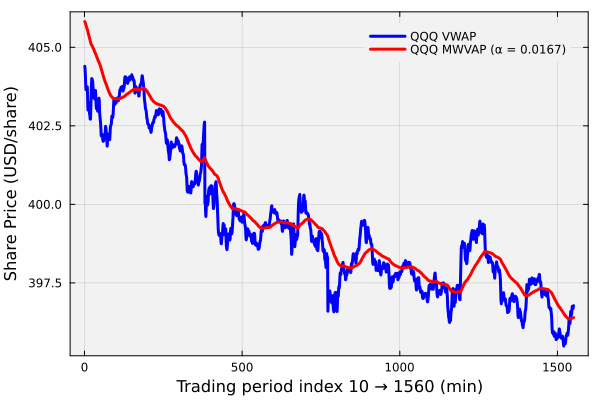

In [134]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, vwap_array[view_range],c=:blue, lw=3, label="QQQ VWAP")
    plot!(mvap_array[view_range], c=:red, lw=3, label="QQQ MWVAP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index $(first(view_range)) → $(last(view_range)) (min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

### TODO: Develop a decision boundary
The `mvwap` gives us a reference trajectory to use as a decision boundary, i.e., a `QQQ` price level that we'll use to make `{buy, hold, sell}` decisions. 
* `Hypothesis`: If `vwap` < `mvwap,` we'll buy shares as we expect `QQQ` is oversold, and the price will revert to the `mvwap` value. On the other hand, if `vwap` > `mvwap`  we will sell. In this case, we expect that `QQQ` is overbought, and the price will drop to the `mvwap` price.

However, let's refine this hypothesis and add a buffer of size $\pm\,\beta\cdot\sigma$ around the `mvwap` in which we hold, where the multiplier $\beta$ is a user-adjustable hyperparameter, and $\sigma$ is the standard deviation.

#### Computation of the decision boundary standard-deviation
Fill me in.

In [20]:
decision_boundary_array = Array{Float64,1}(undef, number_of_trading_periods);
decision_boundary_array[1] = 0.0;
for i ∈ 2:(number_of_trading_periods)
    previous_decision_boundary = decision_boundary_array[i-1];
    current_decision_boundary = (vwap_array[i] - mvap_array[i])^2 |> x -> sqrt(x);
    decision_boundary_array[i] = previous_decision_boundary + α*(current_decision_boundary - previous_decision_boundary);
end

#### Visualize the decision boundary
Fill me in.

In [37]:
β = 1.0;

`Unhide` the code block below to see how we plot the vwap, the mvwap, and the decision boundary trajectory for your choice of the $\beta$ hyperparameter. For the data below, we show the `β = 1` case.
* Fill me in

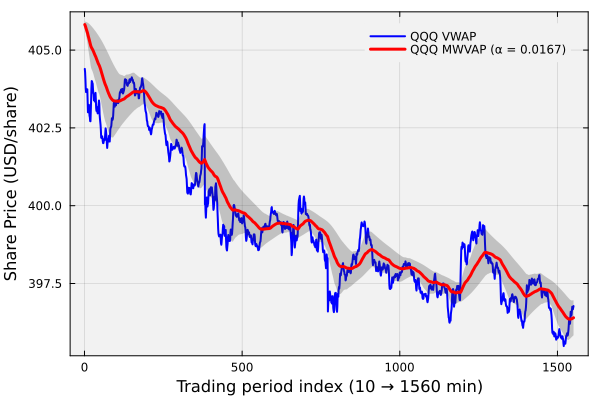

In [144]:
let    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, vwap_array[view_range],c=:blue, lw=2, label = "QQQ VWAP")

    UB = mvap_array[view_range] + β*decision_boundary_array[view_range];
    LB = mvap_array[view_range] - β*decision_boundary_array[view_range];
    plot!(mvap_array[view_range], fillrange = UB, label="", alpha=0.25, c=:gray20)
    plot!(mvap_array[view_range], fillrange = LB, label="", alpha=0.25, c=:gray20)
    plot!(mvap_array[view_range], c=:red, lw = 3, label="QQQ MWVAP (α = $(round(α, digits=4)))")
    xlabel!("Trading period index ($(first(view_range)) → $(last(view_range)) min)", fontsize=18)
    ylabel!("Share Price (USD/share)", fontsize= 18);
end

## Task 2: Formulate Edge and Interior Agent Decision Policies 
Fill me in

## Task 3: Simulate Agent Trading Network Dynamics
Fill me on

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.